### Bibliotecas

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

### Implementação dos Modelos Lineares de Aprendizagem de Máquina

In [241]:
class PerceptronLA:
    def __init__(self, _X, _Y, tmax = 10000):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
        self.tmax = tmax
    
    def fit(self):

        W = np.zeros(self.X.shape[1])
        self.W = np.copy(W)
        indice_class_incorretas = np.arange(len(self.X))
        self.min_erros = len(indice_class_incorretas)

        for i in range(self.tmax):
            indice_aleatorio = np.random.choice(indice_class_incorretas)

            W = W + (self.Y[indice_aleatorio] * self.X[indice_aleatorio])

            qtd_erros = 0
            lista_provisoria = []

            for j in range(len(self.X)):
                classificacao_atual = np.sign(W @ self.X[j])

                if classificacao_atual != self.Y[j]:
                    qtd_erros += 1
                    lista_provisoria.append(j)
            
            indice_class_incorretas = np.array(lista_provisoria)

            if qtd_erros == 0:
                self.W = np.copy(W)
                self.min_erros = qtd_erros
                break

            if qtd_erros < self.min_erros:
                self.W = np.copy(W)
                self.min_erros = qtd_erros
    
    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)
    
    def predict_digit(self):
        self.DPREDICT = np.where(self.PREDICT == -1, 5, self.PREDICT)

In [242]:
class RegressaoLinear:
    def __init__(self, _X, _Y):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
    
    def fit(self):

        matriz_XtX = self.X.T @ self.X
        inversa_matriz_XtX = np.linalg.inv(matriz_XtX)
        matriz_XtY = self.X.T @ self.Y
        
        self.W = inversa_matriz_XtX @ matriz_XtY
    
    def predict(self, _X):
        
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)
    
    def predict_digit(self):
        
        self.DPREDICT = np.where(self.PREDICT == -1, 5, self.PREDICT)

In [243]:
class RegressaoLogistica:
    def __init__(self, _X, _Y, eta = 0.1, tmax = 1000, bs=1000000, lambda_regula = 0.0):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
        self.eta = eta
        self.tmax = tmax
        self.batch_size = bs
        self.lambda_regula = lambda_regula

    def fit(self):

        self.W = np.zeros(self.X.shape[1])

        for t in range(self.tmax):
            
            somatorio = np.zeros(self.X.shape[1])

            if self.batch_size < self.X.shape[0]:
                idx = np.random.choice(len(self.X), size=self.batch_size, replace=False)
                Xb = self.X[idx]
                Yb = self.Y[idx]
            else:
                Xb = self.X
                Yb = self.Y

            for i in range(Xb.shape[0]):
                exponencial = np.exp(Yb[i]*(self.W @ Xb[i]))
                somatorio += (Yb[i]*Xb[i]) / (1 + exponencial)
            
            gradiente = -(1/Xb.shape[0]) * somatorio
            gradiente += (2 * self.lambda_regula / self.X.shape[0]) * self.W

            if np.linalg.norm(gradiente) < 0.00000000000001 :
                break

            self.W = self.W - (self.eta * gradiente)

    def predict_prob(self, _X):
        
        self.PROB = []

        for x in _X:
            z = x @ self.W
            self.PROB.append(1 / (1 + np.exp(-z)))
            
        self.PROB = np.array(self.PROB)

    def predict(self, _X):
        
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.predict_prob(X)
        self.PREDICT = np.empty(len(self.PROB), dtype = int)

        for i in range(len(self.PROB)):
            if self.PROB[i] >= 0.5:
                self.PREDICT[i] = 1
            else:
                self.PREDICT[i] = -1
    
    def predict_digit(self):
        
        self.DPREDICT = np.where(self.PREDICT == -1, 5, self.PREDICT)

### Implementação Weight Decay

In [244]:
def erro_binario(y_real, y_pred):
    
    return np.mean(np.array(y_real) != np.array(y_pred))

In [245]:
def weight_decay_selecao(X_treino, Y_treino, X_val, Y_val, lambdas, eta=0.1, tmax=1000, bs = 1000000):
    
    modelos = []
    erros_val = []

    for lam in lambdas:
        modelo = RegressaoLogistica(X_treino, Y_treino, eta=eta, tmax=tmax, bs=bs, lambda_regula=lam)
        modelo.fit()
        
        modelo.predict(X_val)
        erro = erro_binario(Y_val, modelo.PREDICT)
        
        modelos.append(modelo)
        erros_val.append(erro)
        
        print(f"Lambda = {lam:<10} | Erro validação = {erro:.4f}")
    
    return modelos, erros_val

In [246]:
def weight_decay_completo(X_treino, Y_treino, X_val, Y_val, lambdas, eta=0.1, tmax=1000, bs = 1000000):
    
    _, erros_val = weight_decay_selecao(X_treino, Y_treino, X_val, Y_val, lambdas, eta, tmax, bs)
    
    menor_erro = erros_val[0]
    melhor_idx = 0
    
    for i in range(1, len(erros_val)):
        if erros_val[i] < menor_erro:
            menor_erro = erros_val[i]
            melhor_idx = i
    
    melhor_lambda = lambdas[melhor_idx]
    
    return melhor_lambda

### Implementação Plotagem de Gráfico

In [247]:
def plot_graph(titulo, conjunto_dados, limx1, limx2, limy1, limy2, has_line = False, PLA = 0, RL = 0, RLO = 0, PLA1 = 0, RL1 = 0, RLO1 = 0, PLA2 = 0, RL2 = 0, RLO2 = 0):
    
    label0 = conjunto_dados[conjunto_dados["label"] == 0]
    label1 = conjunto_dados[conjunto_dados["label"] == 1]
    label4 = conjunto_dados[conjunto_dados["label"] == 4]
    label5 = conjunto_dados[conjunto_dados["label"] == 5]
    
    if has_line == True:
        
        fig, ax = plt.subplots(1, 3, figsize=(20, 6))

        # Gráfico do Perceptron

        ax[0].scatter(label0["intensidade"], label0["simetria"], color='blue', marker='o', s=15, alpha=0.6, label = "Dígitos 0")
        ax[0].scatter(label1["intensidade"], label1["simetria"], color='red', marker='x', s=15, alpha=0.6, label = "Dígitos 1")
        ax[0].scatter(label4["intensidade"], label4["simetria"], color='purple', marker='*', s=15, alpha=0.6, label = "Dígitos 4")
        ax[0].scatter(label5["intensidade"], label5["simetria"], color='green', marker='v', s=15, alpha=0.6, label = "Dígitos 5")
        
        x = np.linspace(limx1, limx2, 200)

        y1 = -(PLA.W[1]/PLA.W[2])*x - (PLA.W[0]/PLA.W[2])

        if PLA1 != 0:
            y2 = -(PLA1.W[1]/PLA1.W[2])*x - (PLA1.W[0]/PLA1.W[2])
            y3 = -(PLA2.W[1]/PLA2.W[2])*x - (PLA2.W[0]/PLA2.W[2])

            ax[0].plot(x, y2, linewidth=2, color="pink")
            ax[0].plot(x, y3, linewidth=2, color="black")

        ax[0].plot(x, y1, linewidth=2, color="orange")

        ax[0].set_title(f"Classificação Perceptron: {titulo}")

        ax[0].set_xlim(limx1, limx2)
        ax[0].set_ylim(limy1, limy2)

        ax[0].legend(loc="lower right")

        # Gráfico da Regressão Linear

        ax[1].scatter(label0["intensidade"], label0["simetria"], color='blue', marker='o', s=15, alpha=0.6, label = "Dígitos 0")
        ax[1].scatter(label1["intensidade"], label1["simetria"], color='red', marker='x', s=15, alpha=0.6, label = "Dígitos 1")
        ax[1].scatter(label4["intensidade"], label4["simetria"], color='purple', marker='*', s=15, alpha=0.6, label = "Dígitos 4")
        ax[1].scatter(label5["intensidade"], label5["simetria"], color='green', marker='v', s=15, alpha=0.6, label = "Dígitos 5")

        x = np.linspace(limx1, limx2, 200)

        y1 = -(RL.W[1]/RL.W[2])*x - (RL.W[0]/RL.W[2])
            
        if RL1 != 0:
            y2 = -(RL1.W[1]/RL1.W[2])*x - (RL1.W[0]/RL1.W[2])
            y3 = -(RL2.W[1]/RL2.W[2])*x - (RL2.W[0]/RL2.W[2])

            ax[1].plot(x, y2, linewidth=2, color="pink")
            ax[1].plot(x, y3, linewidth=2, color="black")

        ax[1].plot(x, y1, linewidth=2, color="orange")
    
        ax[1].set_title(f"Classificação Regressão Linear: {titulo}")

        ax[1].set_xlim(limx1, limx2)
        ax[1].set_ylim(limy1, limy2)

        ax[1].legend(loc="lower right")

        # Gráfico da Regressão Logística

        ax[2].scatter(label0["intensidade"], label0["simetria"], color='blue', marker='o', s=15, alpha=0.6, label = "Dígitos 0")
        ax[2].scatter(label1["intensidade"], label1["simetria"], color='red', marker='x', s=15, alpha=0.6, label = "Dígitos 1")
        ax[2].scatter(label4["intensidade"], label4["simetria"], color='purple', marker='*', s=15, alpha=0.6, label = "Dígitos 4")
        ax[2].scatter(label5["intensidade"], label5["simetria"], color='green', marker='v', s=15, alpha=0.6, label = "Dígitos 5")

        x = np.linspace(limx1, limx2, 200)

        y1 = -(RLO.W[1]/RLO.W[2])*x - (RLO.W[0]/RLO.W[2])
            
        if RLO1 != 0:
            y2 = -(RLO1.W[1]/RLO1.W[2])*x - (RLO1.W[0]/RLO1.W[2])
            y3 = -(RLO2.W[1]/RLO2.W[2])*x - (RLO2.W[0]/RLO2.W[2])

            ax[2].plot(x, y2, linewidth=2, color="pink")
            ax[2].plot(x, y3, linewidth=2, color="black")

        ax[2].plot(x, y1, linewidth=2, color="orange")
        
        ax[2].set_title(f"Classificação Regressão Logística: {titulo}")

        ax[2].set_xlim(limx1, limx2)
        ax[2].set_ylim(limy1, limy2)

        ax[2].legend(loc="lower right")

        fig.supxlabel("Intensidade")
        fig.supylabel("Simetria", x=0.09)

        plt.show()
    
    else:
        
        plt.figure(figsize=(7, 5))

        plt.scatter(label0["intensidade"], label0["simetria"], color='blue', marker='o', s=15, alpha=0.6, label = "Dígitos 0")
        plt.scatter(label1["intensidade"], label1["simetria"], color='red', marker='x', s=15, alpha=0.6, label = "Dígitos 1")
        plt.scatter(label4["intensidade"], label4["simetria"], color='purple', marker='*', s=15, alpha=0.6, label = "Dígitos 4")
        plt.scatter(label5["intensidade"], label5["simetria"], color='green', marker='v', s=15, alpha=0.6, label = "Dígitos 5")

        plt.xlim(limx1, limx2)
        plt.ylim(limy1, limy2)

        plt.xlabel("Intensidade")
        plt.ylabel("Simetria")

        plt.title(titulo)
        plt.legend(loc="lower right")
        
        plt.show()

### Classificação dos Dígitos 1x5

Carregando test_redu e train_redu para separar o conjunto de dados para treino em treino (80%) e validação (20%) antes de filtrar. Depois filtrando os dígitos 1 e 5 em cada conjunto (treino, validação e teste)

In [248]:
train_redu = pd.read_csv("DatasetProjeto1/train_redu.csv")
test_redu = pd.read_csv("DatasetProjeto1/test_redu.csv")

train_redu_misturado = train_redu.sample(frac=1, random_state=42).reset_index(drop=True)

tamanho_treino = int(0.8 * len(train_redu_misturado))

train_wd = train_redu_misturado.iloc[:tamanho_treino]
val_wd = train_redu_misturado.iloc[tamanho_treino:]

train1x5 = train_wd[train_wd["label"].isin([1,5])].copy()
val1x5 = val_wd[val_wd["label"].isin([1,5])].copy()
test1x5 = test_redu[test_redu["label"].isin([1,5])].copy()

Realizando o teste de Shapiro Wilk (fazendo uso da biblioteca Scipy) para verificar se o conjunto de dados segue ou se aproxima de uma distribuição normal

In [249]:
stat, p = stats.shapiro(train1x5)

print("Estatística:", stat)
print("p-valor:", p)

if p > 0.05:
    print("Conclusão: A distribuição segue ou se aproxima de uma normal")
else:
    print("Conclusão: A distribuição não segue ou não se aproxima de uma normal")

Estatística: 0.8917367501554899
p-valor: 1.2690237965495312e-40
Conclusão: A distribuição não segue ou não se aproxima de uma normal


Como os dados não seguem uma distribuição normal, aplicamos a Normalização Min/Max, ideal para conjunto de dados que não seguem uma distribuição Gaussiana

In [250]:
scaler = MinMaxScaler()

train1x5[["intensidade", "simetria"]] = scaler.fit_transform(train1x5[["intensidade", "simetria"]])
val1x5[["intensidade", "simetria"]] = scaler.transform(val1x5[["intensidade", "simetria"]])
test1x5[["intensidade", "simetria"]] = scaler.transform(test1x5[["intensidade", "simetria"]])

Plotando os dados de treinamento

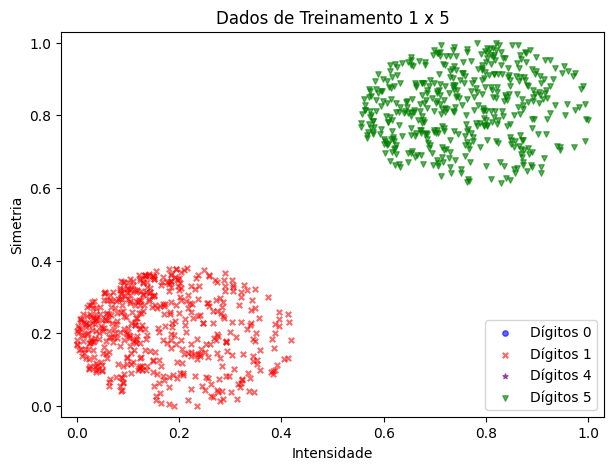

In [251]:
plot_graph("Dados de Treinamento 1 x 5", train1x5, -0.03, 1.03, -0.03, 1.03, False)

Construindo os vetores X e Y (treino, validação e teste) com +1 para label = 1 e -1 para label = 5

In [252]:
X_treino = train1x5[["intensidade", "simetria"]].to_numpy()
Y_treino = train1x5["label"].map({1: 1, 5: -1}).to_numpy()

X_val = val1x5[["intensidade", "simetria"]].to_numpy()
Y_val = val1x5["label"].map({1: 1, 5: -1}).to_numpy()

X_teste = test1x5[["intensidade", "simetria"]].to_numpy()
Y_teste = test1x5["label"].map({1: 1, 5: -1}).to_numpy()

Aplicando a Heurística Weight Decay para a Regressão Logística nos dados 1 x 5

In [253]:
lambdas = [10**k for k in range(-4, 4)]
melhor_lambda = weight_decay_completo(X_treino, Y_treino, X_val, Y_val, lambdas, 0.1, 1000, 32)
print(f"\nLambda escolhido: {melhor_lambda}")

Lambda = 0.0001     | Erro validação = 0.0000
Lambda = 0.001      | Erro validação = 0.0000
Lambda = 0.01       | Erro validação = 0.0000
Lambda = 0.1        | Erro validação = 0.0000
Lambda = 1          | Erro validação = 0.0000
Lambda = 10         | Erro validação = 0.0000
Lambda = 100        | Erro validação = 0.0081
Lambda = 1000       | Erro validação = 0.4839

Lambda escolhido: 0.0001


Treinando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de train1x5

In [254]:
PLAclass = PerceptronLA(X_treino, Y_treino)
RLclass = RegressaoLinear(X_treino, Y_treino)
RLOclass = RegressaoLogistica(X_treino, Y_treino, 0.1, 1000, 32, melhor_lambda)

PLAclass.fit()
RLclass.fit()
RLOclass.fit()

Testando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de test1x5

In [255]:
PLAclass.predict(X_teste)
RLclass.predict(X_teste)
RLOclass.predict(X_teste)

Plotando as retas de cada classificador sobre os dados de teste

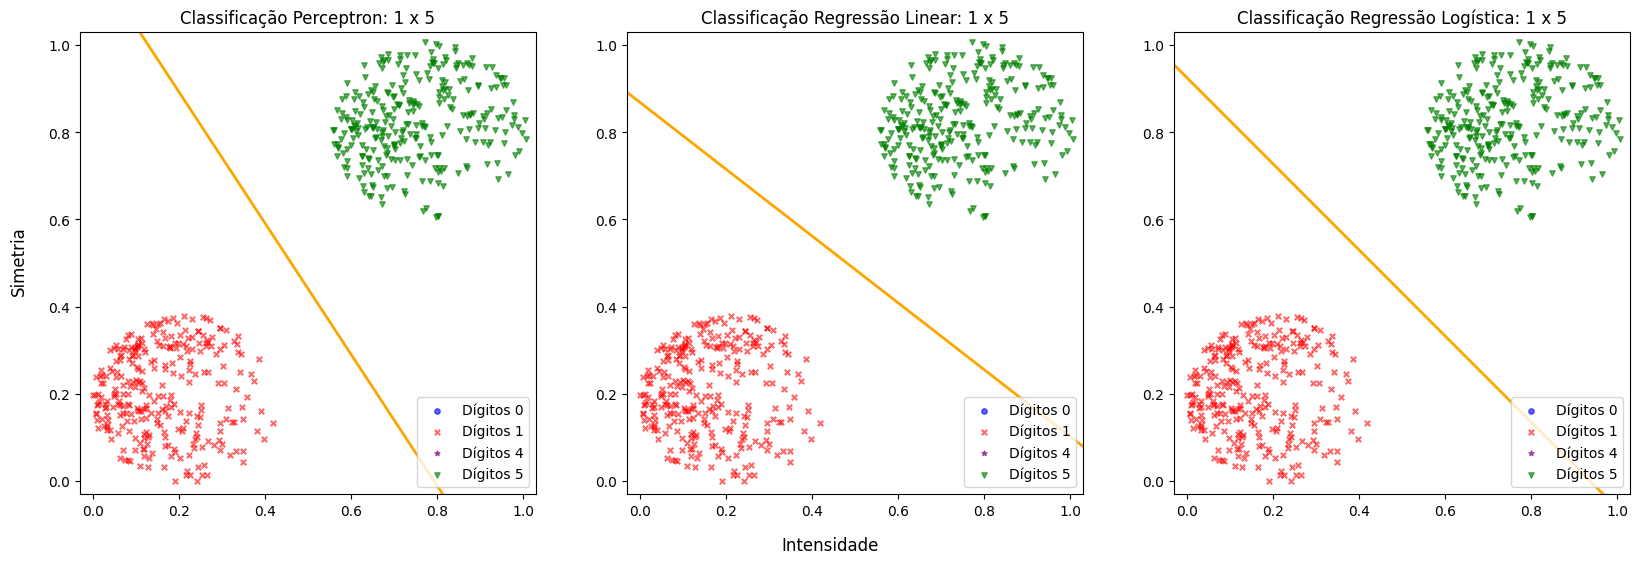

In [256]:
plot_graph("1 x 5", test1x5, -0.03, 1.03, -0.03, 1.03, True, PLAclass, RLclass, RLOclass)

Matriz de Confusão e Relatórios de Eficácia de Classificação

### Classificador de Dígitos Completos

Carregando test_redu e train_redu para separar o conjunto de dados para treino em treino (80%) e validação (20%)

In [257]:
train_redu = pd.read_csv("DatasetProjeto1/train_redu.csv")
test_redu = pd.read_csv("DatasetProjeto1/test_redu.csv")

train_redu_misturado = train_redu.sample(frac=1, random_state=42).reset_index(drop=True)

tamanho_treino = int(0.8 * len(train_redu_misturado))

trainXall = train_redu_misturado.iloc[:tamanho_treino].copy()
valXall = train_redu_misturado.iloc[tamanho_treino:].copy()
testXall = test_redu.copy()

Realizando o teste de Shapiro Wilk (fazendo uso da biblioteca Scipy) para verificar se o conjunto de dados segue ou se aproxima de uma distribuição normal

In [258]:
stat, p = stats.shapiro(trainXall)

print("Estatística:", stat)
print("p-valor:", p)

if p > 0.05:
    print("Conclusão: A distribuição segue ou se aproxima de uma normal")
else:
    print("Conclusão: A distribuição não segue ou não se aproxima de uma normal")

Estatística: 0.8759470777148011
p-valor: 8.414266677119375e-54
Conclusão: A distribuição não segue ou não se aproxima de uma normal


c:\Users\seryn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5244.
  res = hypotest_fun_out(*samples, **kwds)


Como os dados não seguem uma distribuição normal, aplicamos a Normalização Min/Max, ideal para conjunto de dados que não seguem uma distribuição Gaussiana

In [259]:
scaler = MinMaxScaler()

trainXall[["intensidade", "simetria"]] = scaler.fit_transform(trainXall[["intensidade", "simetria"]])
valXall[["intensidade", "simetria"]] = scaler.transform(valXall[["intensidade", "simetria"]])
testXall[["intensidade", "simetria"]] = scaler.transform(testXall[["intensidade", "simetria"]])

Plotando os dados de treinamento

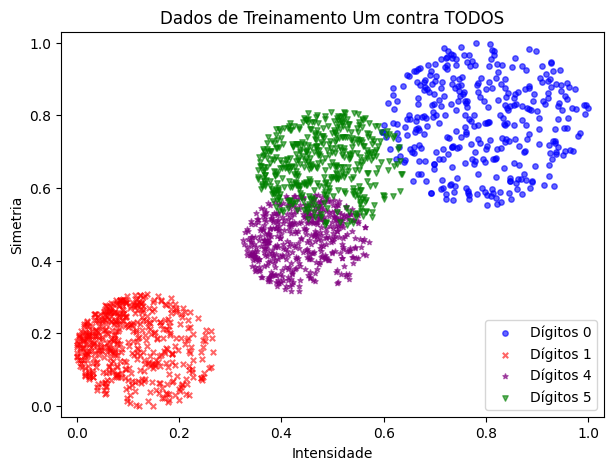

In [260]:
plot_graph("Dados de Treinamento Um contra TODOS", trainXall, -0.03, 1.03, -0.03, 1.03, False)

#### Dígito 0 contra todos

Construindo os vetores X e Y (treino, validação e teste) com +1 para label = 0 e -1 para labels = 1, 4 ou 5

In [261]:
X_treino0Xall = trainXall[["intensidade", "simetria"]].to_numpy()
Y_treino0Xall = trainXall["label"].map({0: 1, 1: -1, 4: -1, 5: -1}).to_numpy()

X_val0Xall = valXall[["intensidade", "simetria"]].to_numpy()
Y_val0Xall = valXall["label"].map({0: 1, 1: -1, 4: -1, 5: -1}).to_numpy()

X_teste0Xall = testXall[["intensidade", "simetria"]].to_numpy()
Y_teste0Xall = testXall["label"].map({0: 1, 1: -1, 4: -1, 5: -1}).to_numpy()

Aplicando a Heurística Weight Decay para a Regressão Logística nos dados 0 contra todos

In [264]:
melhor_lambda = weight_decay_completo(X_treino0Xall, Y_treino0Xall, X_val0Xall, Y_val0Xall, lambdas, 0.1, 10000, 32)
print(f"\nLambda escolhido: {melhor_lambda}")

Lambda = 0.0001     | Erro validação = 0.0091
Lambda = 0.001      | Erro validação = 0.0068
Lambda = 0.01       | Erro validação = 0.0091
Lambda = 0.1        | Erro validação = 0.0091
Lambda = 1          | Erro validação = 0.0297
Lambda = 10         | Erro validação = 0.1324
Lambda = 100        | Erro validação = 0.1689
Lambda = 1000       | Erro validação = 0.1689

Lambda escolhido: 0.001


Treinando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de 0 contra todos

In [265]:
PLAclass0Xall = PerceptronLA(X_treino0Xall, Y_treino0Xall)
RLclass0Xall = RegressaoLinear(X_treino0Xall, Y_treino0Xall)
RLOclass0Xall = RegressaoLogistica(X_treino0Xall, Y_treino0Xall, 0.1, 10000, 32, melhor_lambda)

PLAclass0Xall.fit()
RLclass0Xall.fit()
RLOclass0Xall.fit()

Testando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de 0 contra todos

In [266]:
PLAclass0Xall.predict(X_teste0Xall)
RLclass0Xall.predict(X_teste0Xall)
RLOclass0Xall.predict(X_teste0Xall)

Plotando as retas de cada classificador sobre os dados de teste

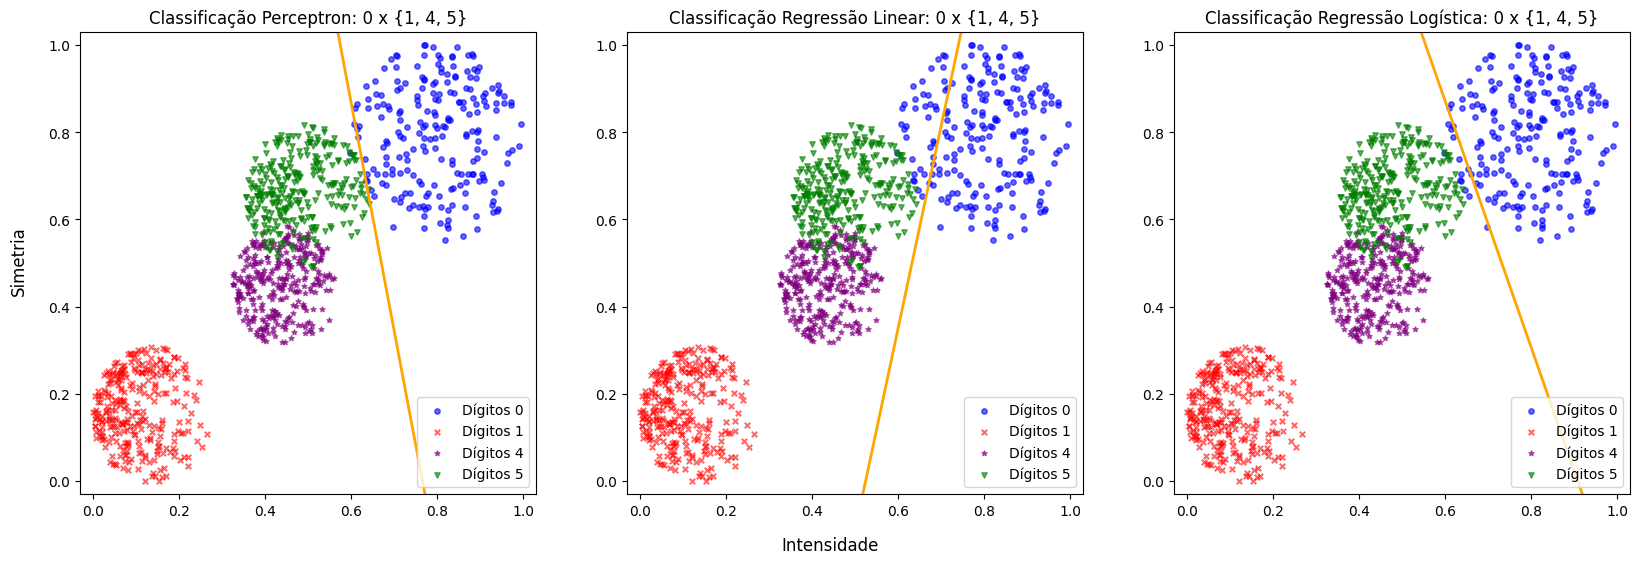

In [267]:
plot_graph("0 x {1, 4, 5}", testXall, -0.03, 1.03, -0.03, 1.03, True, PLAclass0Xall, RLclass0Xall, RLOclass0Xall)

Matriz de Confusão e Relatórios de Eficácia de Classificação

#### Dígito 1 contra todos

Apagando os dados com label = 0 e construindo os vetores X e Y (treino, validação e teste) com +1 para label = 1 e -1 para labels = 4 ou 5

In [268]:
train1Xall = trainXall[trainXall["label"] != 0]
val1Xall   = valXall[valXall["label"] != 0]
test1Xall  = testXall[testXall["label"] != 0]

X_treino1Xall = train1Xall[["intensidade", "simetria"]].to_numpy()
Y_treino1Xall = train1Xall["label"].map({1: 1, 4: -1, 5: -1}).to_numpy()

X_val1Xall = val1Xall[["intensidade", "simetria"]].to_numpy()
Y_val1Xall = val1Xall["label"].map({1: 1, 4: -1, 5: -1}).to_numpy()

X_teste1Xall = test1Xall[["intensidade", "simetria"]].to_numpy()
Y_teste1Xall = test1Xall["label"].map({1: 1, 4: -1, 5: -1}).to_numpy()

Aplicando a Heurística Weight Decay para a Regressão Logística nos dados 1 contra todos

In [269]:
melhor_lambda = weight_decay_completo(X_treino1Xall, Y_treino1Xall, X_val1Xall, Y_val1Xall, lambdas, 0.1, 10000, 32)
print(f"\nLambda escolhido: {melhor_lambda}")

Lambda = 0.0001     | Erro validação = 0.0000
Lambda = 0.001      | Erro validação = 0.0000
Lambda = 0.01       | Erro validação = 0.0000
Lambda = 0.1        | Erro validação = 0.0000
Lambda = 1          | Erro validação = 0.0000
Lambda = 10         | Erro validação = 0.0165
Lambda = 100        | Erro validação = 0.3297
Lambda = 1000       | Erro validação = 0.3297

Lambda escolhido: 0.0001


Treinando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de 1 contra todos

In [270]:
PLAclass1Xall = PerceptronLA(X_treino1Xall, Y_treino1Xall)
RLclass1Xall = RegressaoLinear(X_treino1Xall, Y_treino1Xall)
RLOclass1Xall = RegressaoLogistica(X_treino1Xall, Y_treino1Xall, 0.1, 10000, 32, melhor_lambda)

PLAclass1Xall.fit()
RLclass1Xall.fit()
RLOclass1Xall.fit()

Testando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de 1 contra todos

In [271]:
PLAclass1Xall.predict(X_teste1Xall)
RLclass1Xall.predict(X_teste1Xall)
RLOclass1Xall.predict(X_teste1Xall)

Plotando as retas de cada classificador sobre os dados de teste

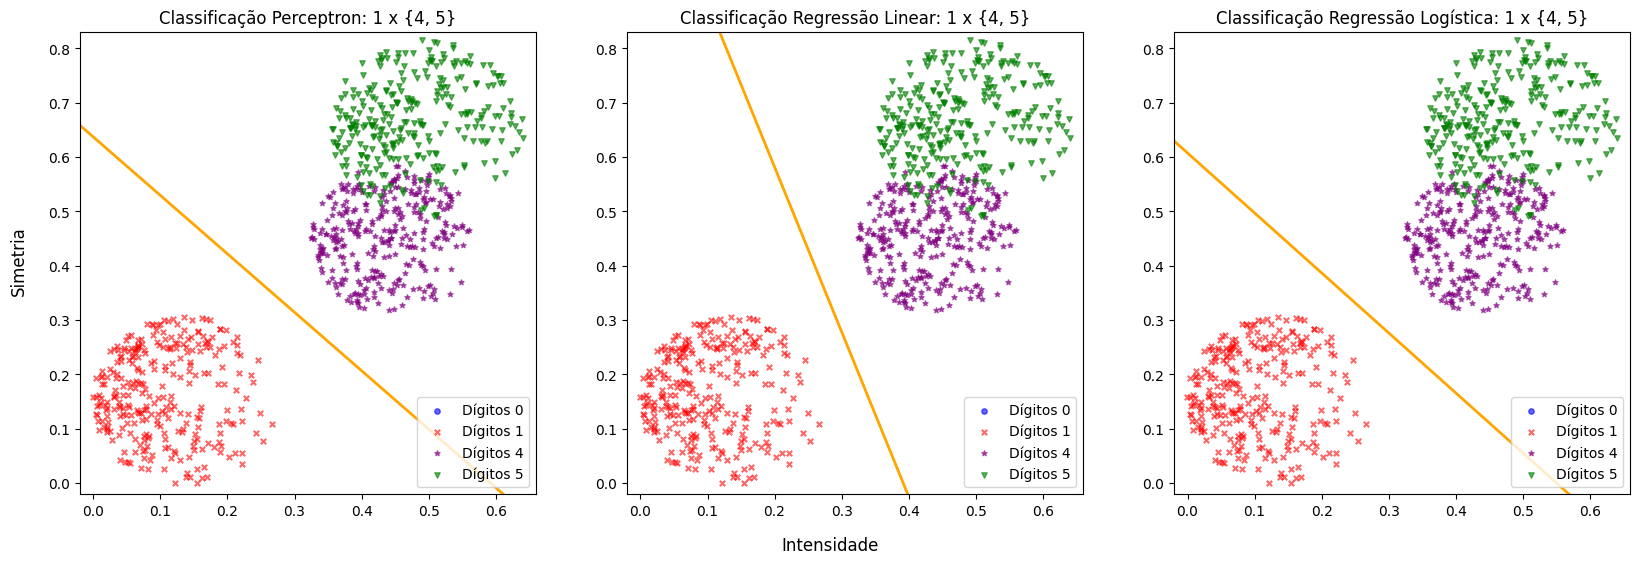

In [272]:
plot_graph("1 x {4, 5}", test1Xall, -0.02, 0.66, -0.02, 0.83, True, PLAclass1Xall, RLclass1Xall, RLOclass1Xall)

Matriz de Confusão e Relatórios de Eficácia de Classificação

#### Dígito 4 contra todos

Apagando os dados com label = 0 e 1 e construindo os vetores X e Y (treino, validação e teste) com +1 para label = 1 e -1 para labels = 4 ou 5

In [273]:
train4Xall = trainXall[(trainXall["label"] != 1) & (trainXall["label"] != 0)]
val4Xall   = valXall[(valXall["label"] != 1) & (valXall["label"] != 0)]
test4Xall  = testXall[(testXall["label"] != 1) & (testXall["label"] != 0)]

X_treino4Xall = train4Xall[["intensidade", "simetria"]].to_numpy()
Y_treino4Xall = train4Xall["label"].map({4: 1, 5: -1}).to_numpy()

X_val4Xall = val4Xall[["intensidade", "simetria"]].to_numpy()
Y_val4Xall = val4Xall["label"].map({4: 1, 5: -1}).to_numpy()

X_teste4Xall = test4Xall[["intensidade", "simetria"]].to_numpy()
Y_teste4Xall = test4Xall["label"].map({4: 1, 5: -1}).to_numpy()

Aplicando a Heurística Weight Decay para a Regressão Logística nos dados 4 contra todos

In [274]:
melhor_lambda = weight_decay_completo(X_treino4Xall, Y_treino4Xall, X_val4Xall, Y_val4Xall, lambdas, 0.1, 10000, 32)
print(f"\nLambda escolhido: {melhor_lambda}")

Lambda = 0.0001     | Erro validação = 0.0738
Lambda = 0.001      | Erro validação = 0.0779
Lambda = 0.01       | Erro validação = 0.0738
Lambda = 0.1        | Erro validação = 0.0738
Lambda = 1          | Erro validação = 0.0820
Lambda = 10         | Erro validação = 0.0820
Lambda = 100        | Erro validação = 0.3607
Lambda = 1000       | Erro validação = 0.4754

Lambda escolhido: 0.0001


Treinando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de 4 contra todos

In [275]:
PLAclass4Xall = PerceptronLA(X_treino4Xall, Y_treino4Xall)
RLclass4Xall = RegressaoLinear(X_treino4Xall, Y_treino4Xall)
RLOclass4Xall = RegressaoLogistica(X_treino4Xall, Y_treino4Xall, 0.1, 10000, 32, melhor_lambda)

PLAclass4Xall.fit()
RLclass4Xall.fit()
RLOclass4Xall.fit()

Testando os três classificadores (Perceptron, Regressão Linear e Regressão Logística) com os dados de 4 contra todos

In [276]:
PLAclass4Xall.predict(X_teste4Xall)
RLclass4Xall.predict(X_teste4Xall)
RLOclass4Xall.predict(X_teste4Xall)

Plotando as retas de cada classificador sobre os dados de teste

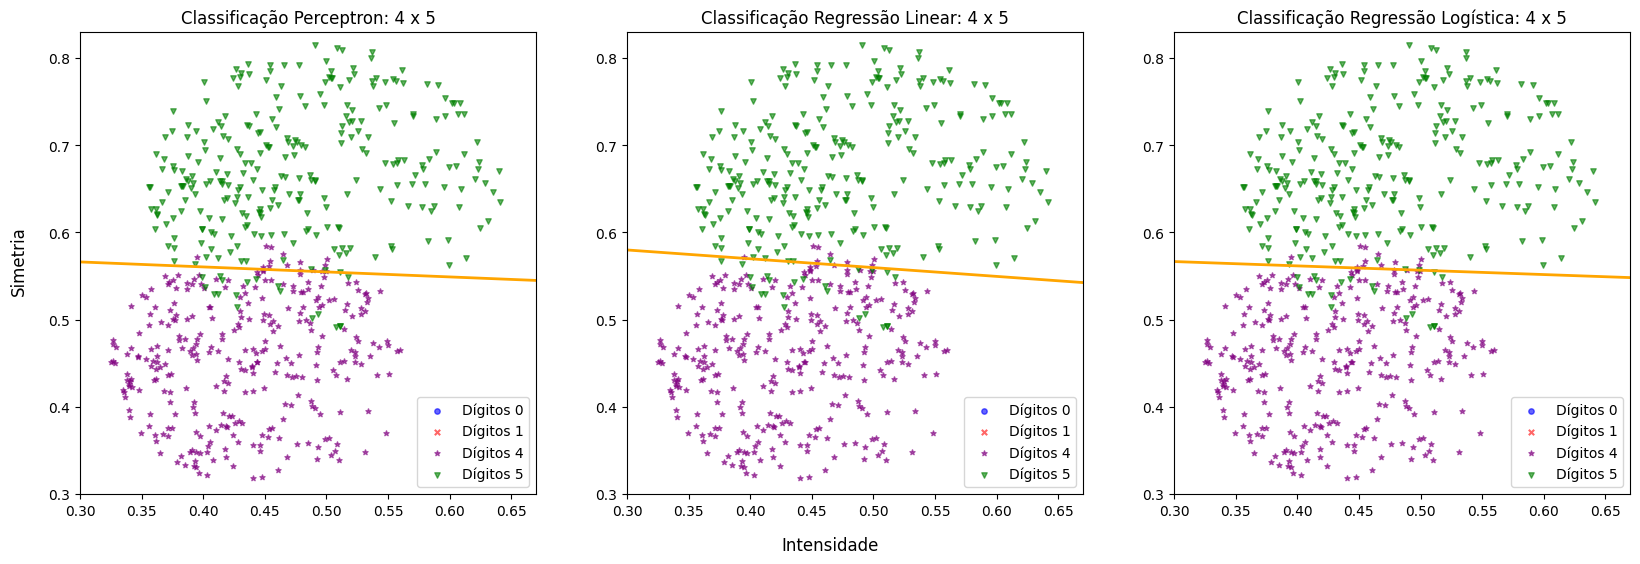

In [277]:
plot_graph("4 x 5", test4Xall, 0.3, 0.67, 0.3, 0.83, True, PLAclass4Xall, RLclass4Xall, RLOclass4Xall)

Matriz de Confusão e Relatórios de Eficácia de Classificação

#### Resultados

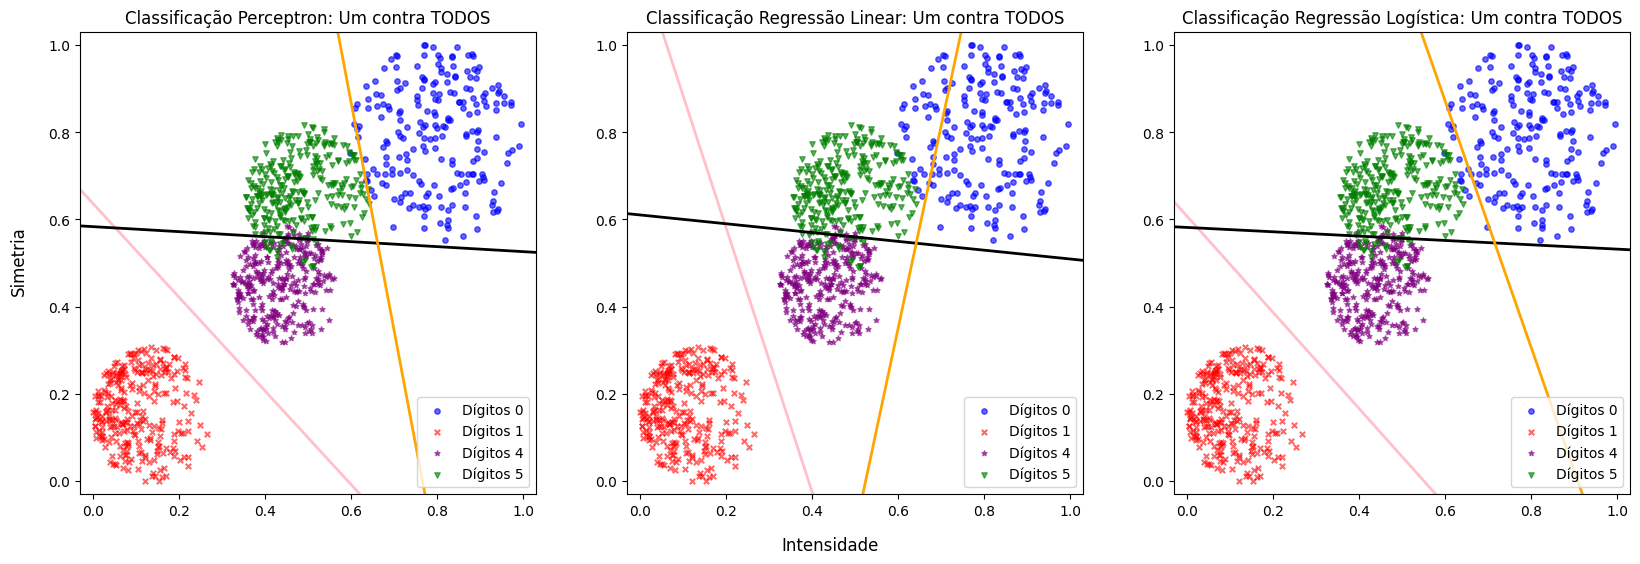

In [278]:
plot_graph("Um contra TODOS", testXall, -0.03, 1.03, -0.03, 1.03, True, PLAclass0Xall, RLclass0Xall, RLOclass0Xall, PLAclass1Xall, RLclass1Xall, RLOclass1Xall, PLAclass4Xall, RLclass4Xall, RLOclass4Xall)